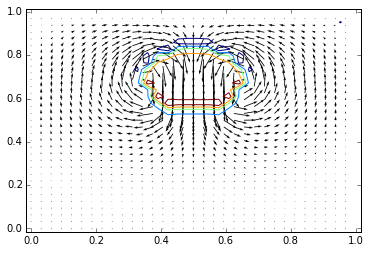

KeyboardInterrupt: 

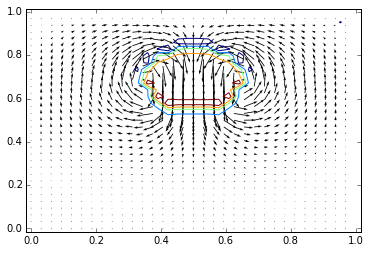

In [209]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
%matplotlib inline

#domain size and physical variables
Lx=1.0
Ly=1.0
gx=0.0
gy=-100.0
rho1=1.0
rho2=2.0
m0=0.01
rro=rho1

unorth=0.
usouth=0.
veast=0.
vwest=0.
time=0.0
#Initial drop size and location
rad=0.15 
xc=0.5
yc=0.7
#layer
start_layer=.7
layer_thickness=.5

#Numerical variables
nx=32
ny=32
dt=0.00125
nstep=100
maxiter=200
maxError=0.001
beta=1.2


u=np.zeros((nx+1,ny+2))
v=np.zeros((nx+2,ny+1))
p=np.zeros((nx+2,ny+2))

ut=np.zeros((nx+1,ny+2))
vt=np.zeros((nx+2,ny+1))
tmp1=np.zeros((nx+2,ny+2))
uu=np.zeros((nx+1,ny+1))
vv=np.zeros((nx+1,ny+1))
tmp2=np.zeros((nx+2,ny+2))
#Set the grid
dx=Lx/(nx) #NEED TO CHECK!
dy=Ly/(ny)

x=np.linspace(-0.5*dx,(nx+.5)*dx,nx+2)
y=np.linspace(-0.5*dy,(ny+.5)*dy,nx+2)
#for i=1:nx+2; x(i)=dx*(i-1.5);end; for j=1:ny+2; y(j)=dy*(j-1.5);end;

r=np.ones((nx+2,ny+2))*rho1
#Sphere
for i in range(1,nx+1):
    for j in range(1,ny+1):
        if ((x[i]-xc)**2+(y[j]-yc)**2)<rad**2:
            r[i,j]=rho2
#Layer
#for i in range(0,nx+2):
#    for j in range(0,ny+2):
#        if (y[j]>start_layer) and (y[j]<(start_layer+layer_thickness)):
#            r[i,j]=rho2
            
time=0.
for steps in range(nstep):
    #tangential velocity at boundaries
    u[:,0]=2.*usouth-u[:,1]
    u[:,-1]=2.*unorth-u[:,-2]
    v[0,:]=2.*vwest-v[1,:]
    v[-1,:]=2.*veast-v[-2,:]
    
    ut[1:nx-1,1:ny]=u[1:nx-1,1:ny]+dt*(-0.25*(((u[2:nx,1:ny]+u[1:nx-1,1:ny])**2-(u[1:nx-1,1:ny]+\
        u[0:nx-2,1:ny])**2)/dx+((u[1:nx-1,2:ny+1]+u[1:nx-1,1:ny])*(v[2:nx,1:ny]+\
        v[1:nx-1,1:ny])-(u[1:nx-1,1:ny]+u[1:nx-1,0:ny-1])*(v[2:nx,0:ny-1]+v[1:nx-1,0:ny-1]))/dy)+\
        m0/(0.5*(r[2:nx,1:ny]+r[1:nx-1,1:ny]))*(\
        (u[2:nx,1:ny]-2*u[1:nx-1,1:ny]+u[0:nx-2,1:ny])/dx**2+\
        (u[1:nx-1,2:ny+1]-2*u[1:nx-1,1:ny]+u[1:nx-1,0:ny-1])/dy**2 )+gx)

    vt[1:nx,1:ny-1]=v[1:nx,1:ny-1]+dt*(-0.25*(((u[1:nx,2:ny]+u[1:nx,1:ny-1])*(v[2:nx+1,1:ny-1]+\
                v[1:nx,1:ny-1])-(u[0:nx-1,2:ny]+u[0:nx-1,1:ny-1])*(v[1:nx,1:ny-1]+v[0:nx-1,1:ny-1]))/dx+\
                ((v[1:nx,2:ny]+v[1:nx,1:ny-1])**2-(v[1:nx,1:ny-1]+v[1:nx,0:ny-2])**2)/dy)+\
                m0/(0.5*(r[1:nx,2:ny]+r[1:nx,1:ny-1]))*(\
                (v[2:nx+1,1:ny-1]-2*v[1:nx,1:ny-1]+v[0:nx-1,1:ny-1])/dx**2+\
                (v[1:nx,2:ny]-2*v[1:nx,1:ny-1]+v[1:nx,0:ny-2])/dy**2 )+gy)

    #Compute source term and the coefficient for p(i,j)
    rt=r.copy()
    lrg=1000.
    rt[:,0]=lrg
    rt[:,-1]=lrg
    rt[0,:]=lrg
    rt[-1,:]=lrg
    
    tmp1[1:nx,1:ny]=(0.5/dt)*((ut[1:nx,1:ny]-ut[0:nx-1,1:ny])/dx+\
        (vt[1:nx,1:ny]-vt[1:nx,0:ny-1])/dy)
#    tmp2[1:nx,1:ny]=1.0/((1./dx)*(1./(dx*(rt[2:nx+1,1:ny]+rt[1:nx,1:ny]))+\
#        1./(dx*(rt[0:nx-1,1:ny]+rt[1:nx,1:ny])))+\
#        (1./dy)*(1./(dy*(rt[1:nx,2:ny+1]+rt[1:nx,1:ny]))+\
#        1./(dy*(rt[1:nx,0:ny-1]+rt[1:nx,1:ny])))) 
    
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            tmp2[i,j]=1.0/( (1./dx)*( 1./(dx*(rt[i+1,j]+rt[i,j]))+\
                1./(dx*(rt[i-1,j]+rt[i,j]))  )+\
                (1./dy)*(1./(dy*(rt[i,j+1]+rt[i,j]))+\
                1./(dy*(rt[i,j-1]+rt[i,j])))) 

#           tmp1[i,j]= (0.5/dt)*( (ut[i,j]-ut[i-1,j])/dx+(vt[i,j]-vt[i,j-1])/dy )

    iter=0
    while True:
        pn=p.copy()
        iter=iter+1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                    (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                    p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                    (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                    p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])
        if np.abs(pn-p).max()<maxError:
            break
        if iter>maxiter:
            break
            
# CORRECT THE u-velocity
    u[1:nx-1,1:ny]=ut[1:nx-1,1:ny]-dt*(2.0/dx)*\
        (p[2:nx,1:ny]-p[1:nx-1,1:ny])/(r[2:nx,1:ny]+r[1:nx-1,1:ny])
# CORRECT THE v-velocity
    v[1:nx,1:ny-1]=vt[1:nx,1:ny-1]-dt*(2.0/dy)*\
        (p[1:nx,2:ny]-p[1:nx,1:ny-1])/(r[1:nx,2:ny]+r[1:nx,1:ny-1])    

#=======ADVECT DENSITY using centered difference plus diffusion ==========
    ro=r.copy()
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            r[i,j]=ro[i,j]-(0.5*dt/dx)*(u[i,j]*(ro[i+1,j]\
                    +ro[i,j])-u[i-1,j]*(ro[i-1,j]+ro[i,j]))\
                    -(0.5* dt/dy)*(v[i,j]*(ro[i,j+1]\
                    +ro[i,j])-v[i,j-1]*(ro[i,j-1]+ro[i,j]))\
                    +(m0*1e-3*dt/dx/dx)*(ro[i+1,j]-2.0*ro[i,j]+ro[i-1,j])\
                    +(m0*1e-3*dt/dy/dy)*(ro[i,j+1]-2.0*ro[i,j]+ro[i,j-1])
                    
    time=time+dt
    #Plot the density contour and the velocity field
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,1:ny+1])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
    yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
    plt.clf()
    plt.quiver(xx,yy,uu.T,vv.T)
    plt.contour(x,y,r.T,5);
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #print steps

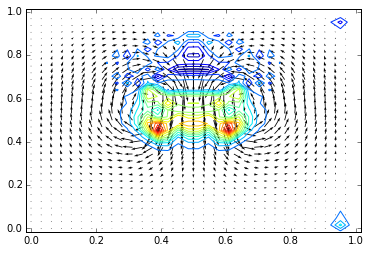

In [200]:
uu.max()

4.5931179547586272